In [38]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from APP_Constants import APP_constants as CN
from APP_logger.app_logger import APP_Logger
from APP_utils.common_utils import reduce_memory_usage , Read_data_MONGO , profile_report_
from APP_Database_operations.mongodb_operations import MongoDB

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


# from sklearn.preprocessing import LabelEncoder

# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.feature_selection import RFE
# from sklearn.metrics import *
# import pickle

In [26]:

def select_features(features , labels , N2_select):    

    
    EXtra_selected=ExtraTreesClassifier()
    EXtra_selected.fit(features,labels)
    EXtra_selected_features=pd.DataFrame(EXtra_selected.feature_importances_,columns=["Score_EXtraTree"] , index=features.columns)

    mutual_info=mutual_info_classif(features,labels)
    mutual_data=pd.DataFrame(mutual_info,index=features.columns , columns=["Score_mutual_info"])
    
    clf1 = RandomForestClassifier(random_state=42)
    selector = RFE(estimator = clf1, n_features_to_select=N2_select, step=1)
    selector = selector.fit(features, labels)
    rfa_selected = pd.DataFrame(selector.ranking_ , columns=["Score_RFE"] , index=features.columns)



    return pd.concat([EXtra_selected_features , mutual_data , rfa_selected],axis=1)
    


In [5]:
MONGO_DB =CN.MONGO_DB_NAME 
PROCESSED_COLLECTION=CN.MONGO_PROCESSED_COLLECTION 
Conn_obj_Processed = MongoDB( MONGO_DB , PROCESSED_COLLECTION)

In [6]:
processed_data_df = Read_data_MONGO(Conn_obj_Processed , Del_id = True)

Reading the data from the database
Dataframe created successfully


In [7]:
processed_data_df

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,forest
0,-0.920196,1.204630,-0.567430,0.223385,-2.134346,-1.017462,-0.879373,-1.083713,-0.996470,-0.942348,No Fire,1.010363
1,0.779975,-1.629712,-0.213471,-0.370594,0.997411,2.819631,1.965357,1.769359,2.553524,2.629802,Fire,1.010363
2,-0.920196,1.811989,-0.921390,-0.037966,-3.043566,-1.056536,-0.879373,-1.155639,-1.023621,-0.955676,No Fire,-0.989743
3,-0.070110,1.272114,0.494449,-0.370594,0.456209,0.459546,-0.174789,-0.028795,0.245689,0.070650,Fire,1.010363
4,1.063337,-0.549962,0.848409,-0.370594,0.802579,0.373582,1.218133,1.169975,0.693680,1.190279,Fire,-0.989743
...,...,...,...,...,...,...,...,...,...,...,...,...
189,0.496613,0.597271,-0.567430,0.223385,-0.994213,-0.931498,-0.848915,-0.915885,-0.935380,-0.902361,No Fire,1.010363
190,-0.070110,-0.752415,-0.921390,-0.370594,0.752066,0.060988,-0.014380,0.498664,0.035268,0.350557,Fire,1.010363
191,0.496613,0.124881,-0.567430,-0.370594,0.766499,1.975627,2.444555,1.002147,2.282014,1.830067,Fire,-0.989743
192,-1.770281,1.339599,2.264248,0.223385,-2.249802,-0.994017,-0.889525,-1.083713,-0.989682,-0.942348,No Fire,-0.989743


In [8]:
processed_data_df = reduce_memory_usage(processed_data_df)

Memory usage decreased from 0.03MB to 0.01MB (0.02MB, 68.96% reduction)


In [9]:
profile_report_(processed_data_df, title='Processed' , display_report=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile Report Generated for Processed saved to /home/pk/Desktop/Eda/Algerian_forest_fires_dataset/templates/Processed_profile.html


'file saved to /home/pk/Desktop/Eda/Algerian_forest_fires_dataset/templates/Processed_profile.html'

In [10]:
X = processed_data_df.drop(['Classes'], axis=1)
y= processed_data_df['Classes']

In [27]:
select_df_11 = select_features(X , y , N2_select=10)

In [28]:
select_df_11

,Score_EXtraTree,Score_mutual_info,Score_RFE
Temperature,0.025882,0.148734,1
RH,0.030174,0.088158,1
Ws,0.011466,0.000000,1
Rain,0.125176,0.239738,1
FFMC,0.171230,0.629096,1
DMC,0.060426,0.347332,1
DC,0.058448,0.306991,1
ISI,0.212505,0.636854,1
BUI,0.088130,0.340114,1
FWI,0.204826,0.553260,1


lets Drop the Forest  as mutual_info_classif , ExtraTreesClassifier , RFE  indicates that Forest are not good at feature selection

In [29]:
X_10 = X.drop(['forest'], axis=1)

In [30]:
select_df_10 = select_features(X_10 , y , N2_select=9)

In [31]:
select_df_10

,Score_EXtraTree,Score_mutual_info,Score_RFE
Temperature,0.033832,0.169511,1
RH,0.025900,0.116938,1
Ws,0.013472,0.000000,2
Rain,0.129610,0.249862,1
FFMC,0.220178,0.629096,1
DMC,0.059195,0.359875,1
DC,0.065560,0.308371,1
ISI,0.162138,0.631998,1
BUI,0.054328,0.340888,1
FWI,0.235787,0.549675,1


In [32]:
select_df_10.sort_values(by=['Score_EXtraTree'], ascending=False)

,Score_EXtraTree,Score_mutual_info,Score_RFE
FWI,0.235787,0.549675,1
FFMC,0.220178,0.629096,1
ISI,0.162138,0.631998,1
Rain,0.129610,0.249862,1
DC,0.065560,0.308371,1
DMC,0.059195,0.359875,1
BUI,0.054328,0.340888,1
Temperature,0.033832,0.169511,1
RH,0.025900,0.116938,1
Ws,0.013472,0.000000,2



Based on the data the FWI components are derived from the below information:

1. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
2. RH : Relative Humidity in %: 21 to 90
3. Ws :Wind speed in km/h: 6 to 29
4. Rain: total day in mm: 0 to 16.8



FWI Components are as follows :

1. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
2. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
3. Drought Code (DC) index from the FWI system: 7 to 220.4
4. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
5. Buildup Index (BUI) index from the FWI system: 1.1 to 68
6. Fire Weather Index (FWI) Index: 0 to 31.1




Citation : 

Faroudja ABID et al. , â€œPredicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithmâ€, International Conference on Advanced Intelligent Systems for 
Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco.

https://www.researchgate.net/profile/Faroudja-Abid/publication/339062373_Predicting_Forest_Fire_in_Algeria_Using_Data_Mining_Techniques_Case_Study_of_the_Decision_Tree_Algorithm/links/5f6862e4a6fdcc008631dcd8/Predicting-Forest-Fire-in-Algeria-Using-Data-Mining-Techniques-Case-Study-of-the-Decision-Tree-Algorithm.pdf

As the data despcrition shows the FWI components are derived from the below information: from the we will use the derived columns as the feature to train the model 

In [33]:
select_df_6 = select_features(X_10 , y , N2_select=6)

In [34]:
select_df_6

,Score_EXtraTree,Score_mutual_info,Score_RFE
Temperature,0.040064,0.158347,4
RH,0.030608,0.080382,3
Ws,0.014213,0.006621,5
Rain,0.128918,0.324024,2
FFMC,0.229576,0.629096,1
DMC,0.076577,0.337082,1
DC,0.052830,0.307635,1
ISI,0.155683,0.633099,1
BUI,0.083565,0.332812,1
FWI,0.187965,0.550362,1


In [35]:
select_df_6.sort_values(by=['Score_EXtraTree'], ascending=False)

,Score_EXtraTree,Score_mutual_info,Score_RFE
FFMC,0.229576,0.629096,1
FWI,0.187965,0.550362,1
ISI,0.155683,0.633099,1
Rain,0.128918,0.324024,2
BUI,0.083565,0.332812,1
DMC,0.076577,0.337082,1
DC,0.052830,0.307635,1
Temperature,0.040064,0.158347,4
RH,0.030608,0.080382,3
Ws,0.014213,0.006621,5


In [47]:
select_df_6.sort_values(by=['Score_mutual_info'], ascending=False)

,Score_EXtraTree,Score_mutual_info,Score_RFE
ISI,0.155683,0.633099,1
FFMC,0.229576,0.629096,1
FWI,0.187965,0.550362,1
DMC,0.076577,0.337082,1
BUI,0.083565,0.332812,1
Rain,0.128918,0.324024,2
DC,0.052830,0.307635,1
Temperature,0.040064,0.158347,4
RH,0.030608,0.080382,3
Ws,0.014213,0.006621,5


<AxesSubplot:>

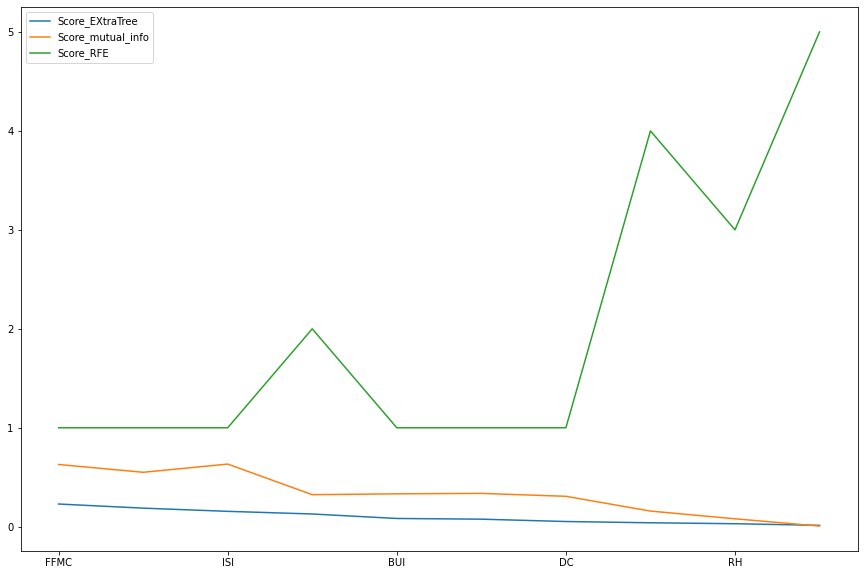

In [46]:

select_df_6.sort_values(by=['Score_EXtraTree'], ascending=False).plot.line(figsize=(15,10))

The rain is the only feature we notice in the not select_features_df_we will use 7 features to analyes the data

In [49]:
select_df_7 = select_features(X_10 , y , N2_select=7)

In [52]:
select_df_7.sort_values(by=['Score_RFE'])

,Score_EXtraTree,Score_mutual_info,Score_RFE
Rain,0.109206,0.237843,1
FFMC,0.211276,0.627378,1
DMC,0.079611,0.348019,1
DC,0.039609,0.307635,1
ISI,0.197613,0.635956,1
BUI,0.071870,0.334427,1
FWI,0.229448,0.551737,1
RH,0.023873,0.096083,2
Temperature,0.027734,0.204630,3
Ws,0.009761,0.000000,4


<AxesSubplot:>

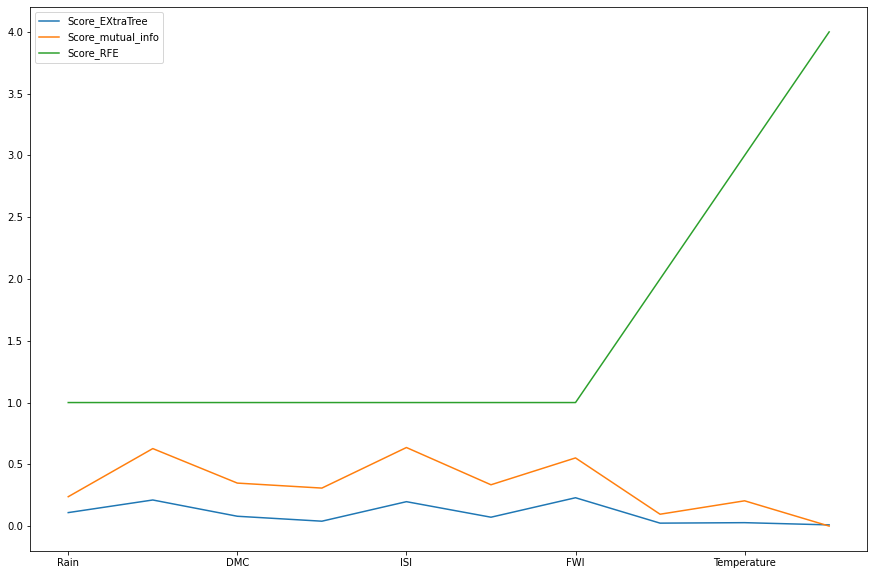

In [55]:
select_df_7.sort_values(by=['Score_RFE']).plot.line(figsize=(15,10))

In [56]:
select_df_7.sort_values(by=['Score_RFE']).head(7)

,Score_EXtraTree,Score_mutual_info,Score_RFE
Rain,0.109206,0.237843,1
FFMC,0.211276,0.627378,1
DMC,0.079611,0.348019,1
DC,0.039609,0.307635,1
ISI,0.197613,0.635956,1
BUI,0.071870,0.334427,1
FWI,0.229448,0.551737,1


In [65]:
Selected_Features_Columns = select_df_7.sort_values(by=['Score_RFE']).head(7).index.to_list()

In [68]:
Selected_Features_Columns

['Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']